Code chạy predict trước
Sau đó chạy Bayesian optimization để hyperparameter tuning cho learning rate, epochs, số layers, hidden units

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import necessary packages

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
from sklearn import preprocessing

%matplotlib inline
import matplotlib.pyplot as plt

Read excel file by Pandas

In [ ]:
import os
folder_path= "/content/drive/My Drive/MathforAI"

def filepath(file_name):
  fname = '{}.csv'.format(file_name)
  fpath = os.path.join(folder_path, fname)
  return(fpath)

df = pd.read_csv(filepath('datapj'), encoding='utf-8', sep=',')
df.head()

,CONTRACT_NO,VINTAGE,LOAN_AMT_WITH_INS,INTEREST_RATE,TENURE,PRODUCT,AGE,GENDER,MARITAL_STATUS,SOCIAL_STATUS,EDUCATION,POS_PROVINCE,PROVINCE_CITY_CURRENT,FB_MEMBERS,PERSONAL_INCOME,DEBT_GROUP
0,20171110-0002628,201801,7339500,45.0,12,CDL,27,MALE,SINGLE,BLUE-COLLAR,2,101.47,10330.15,1,7000000,3
1,20171211-7916965,201801,6605550,55.0,12,CDL,48,MALE,MARRIED,WHITE-COLLAR,3,101.47,10330.15,3,7000000,2
2,20171221-0003360,201801,44200000,45.0,12,TW,41,MALE,SINGLE,BLUE-COLLAR,3,101.47,10330.15,5,13000000,1
3,20171204-0004175,201801,16880000,53.0,24,XSELL,38,MALE,MARRIED,BLUE-COLLAR,3,101.47,8462.58,3,6000000,3
4,20171212-0001990,201801,10550000,47.0,24,XSELL,31,MALE,SINGLE,BLUE-COLLAR,3,101.47,8462.58,4,5000000,3


Drop unnecesary column

In [ ]:
df.drop(columns=['CONTRACT_NO'] )

,VINTAGE,LOAN_AMT_WITH_INS,INTEREST_RATE,TENURE,PRODUCT,AGE,GENDER,MARITAL_STATUS,SOCIAL_STATUS,EDUCATION,POS_PROVINCE,PROVINCE_CITY_CURRENT,FB_MEMBERS,PERSONAL_INCOME,DEBT_GROUP
0,201801,7339500,45.00,12,CDL,27,MALE,SINGLE,BLUE-COLLAR,2,101.47,10330.15,1,7000000,3
1,201801,6605550,55.00,12,CDL,48,MALE,MARRIED,WHITE-COLLAR,3,101.47,10330.15,3,7000000,2
2,201801,44200000,45.00,12,TW,41,MALE,SINGLE,BLUE-COLLAR,3,101.47,10330.15,5,13000000,1
3,201801,16880000,53.00,24,XSELL,38,MALE,MARRIED,BLUE-COLLAR,3,101.47,8462.58,3,6000000,3
4,201801,10550000,47.00,24,XSELL,31,MALE,SINGLE,BLUE-COLLAR,3,101.47,8462.58,4,5000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600584,201810,28782000,21.44,18,TW,42,MALE,DIVORCED,BLUE-COLLAR,3,94.86,7650.75,5,15000000,3
600585,201810,21100000,47.00,18,XSELL,36,FEMALE,MARRIED,BLUE-COLLAR,3,101.47,5095.76,5,3906000,1
600586,201810,21100000,50.00,18,XSELL,61,MALE,MARRIED,WHITE-COLLAR,3,101.47,10330.15,4,6000000,2
600587,201810,45000000,43.00,24,XSELL,39,MALE,MARRIED,BLUE-COLLAR,3,101.47,5190.27,5,10000000,3


Transform non-numerical labels to numerical labels.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Find all unique value of columns need encoding
u_vintage = np.unique(df['VINTAGE'])

# Match initial label with new index encoded by LabelEncoder function
le = LabelEncoder()
label_vintage = le.fit_transform(df['VINTAGE'])
mapping_vintage = {index: label for index, label in 
                  enumerate(le.classes_)}
                  
df['VINTAGE'] = label_vintage
df['INTEREST_RATE'] = df['INTEREST_RATE']/10
df[['VINTAGE','INTEREST_RATE']]

,VINTAGE,INTEREST_RATE
0,0,4.500
1,0,5.500
2,0,4.500
3,0,5.300
4,0,4.700
...,...,...
600584,9,2.144
600585,9,4.700
600586,9,5.000
600587,9,4.300


In [ ]:
# Find all unique value of columns need encoding
u_product= np.unique(df['PRODUCT'])
u_gender = np.unique(df['GENDER'])
u_marital = np.unique(df['MARITAL_STATUS'])
u_social = np.unique(df['SOCIAL_STATUS'])
u_debt = np.unique(df['DEBT_GROUP'])

# Match initial label with new index encoded by LabelEncoder function
le = LabelEncoder()
label_product = le.fit_transform(df['PRODUCT'])
mapping_product = {index: label for index, label in 
                  enumerate(le.classes_)}

label_gender = le.fit_transform(df['GENDER'])
mapping_gender = {index: label for index, label in 
                  enumerate(le.classes_)}

label_marital = le.fit_transform(df['MARITAL_STATUS'])
mapping_marital = {index: label for index, label in 
                  enumerate(le.classes_)}

label_social = le.fit_transform(df['SOCIAL_STATUS'])
mapping_social = {index: label for index, label in 
                  enumerate(le.classes_)}

label_debt = le.fit_transform(df['DEBT_GROUP'])
mapping_debt = {index: label for index, label in 
                  enumerate(le.classes_)}

#One hot encoding
product_onehot = pd.get_dummies(df['PRODUCT'], prefix='PRODUCT')
gender_onehot = pd.get_dummies(df['GENDER'], prefix='GENDER')
marital_onehot = pd.get_dummies(df['MARITAL_STATUS'], prefix='MARITAL_STATUS')
social_onehot = pd.get_dummies(df['SOCIAL_STATUS'], prefix='SOCIAL_STATUS')
debt_onehot = pd.get_dummies(df['DEBT_GROUP'], prefix='DEBT_GROUP')

#Concatenate one hot encoding column to dataset
endf = pd.concat([df[['VINTAGE', 'LOAN_AMT_WITH_INS', 'INTEREST_RATE','TENURE','AGE','EDUCATION','POS_PROVINCE'
                     ,'PROVINCE_CITY_CURRENT','FB_MEMBERS','PERSONAL_INCOME']]
                     , product_onehot, gender_onehot, marital_onehot, social_onehot,debt_onehot], axis=1)
endf

,VINTAGE,LOAN_AMT_WITH_INS,INTEREST_RATE,TENURE,AGE,EDUCATION,POS_PROVINCE,PROVINCE_CITY_CURRENT,FB_MEMBERS,PERSONAL_INCOME,...,SOCIAL_STATUS_PENSIONER,SOCIAL_STATUS_SELF-EMPLOYED,SOCIAL_STATUS_STUDENT,SOCIAL_STATUS_UNEMPLOYED,SOCIAL_STATUS_WHITE-COLLAR,DEBT_GROUP_1,DEBT_GROUP_2,DEBT_GROUP_3,DEBT_GROUP_4,DEBT_GROUP_5
0,0,7339500,4.500,12,27,2,101.47,10330.15,1,7000000,...,0,0,0,0,0,0,0,1,0,0
1,0,6605550,5.500,12,48,3,101.47,10330.15,3,7000000,...,0,0,0,0,1,0,1,0,0,0
2,0,44200000,4.500,12,41,3,101.47,10330.15,5,13000000,...,0,0,0,0,0,1,0,0,0,0
3,0,16880000,5.300,24,38,3,101.47,8462.58,3,6000000,...,0,0,0,0,0,0,0,1,0,0
4,0,10550000,4.700,24,31,3,101.47,8462.58,4,5000000,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600584,9,28782000,2.144,18,42,3,94.86,7650.75,5,15000000,...,0,0,0,0,0,0,0,1,0,0
600585,9,21100000,4.700,18,36,3,101.47,5095.76,5,3906000,...,0,0,0,0,0,1,0,0,0,0
600586,9,21100000,5.000,18,61,3,101.47,10330.15,4,6000000,...,0,0,0,0,1,0,1,0,0,0
600587,9,45000000,4.300,24,39,3,101.47,5190.27,5,10000000,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Save feature dataset và label to numpy array
npdf = endf.to_numpy()
data = npdf[:,0:28] 
label = npdf[:,28:33] 


Natural logarithm on financial data

In [ ]:
#Natural logarithm of financial data on training, validation and test set
def logaritdata(ds):
  ds[:,1:2] = np.log(ds[:,1:2])
  ds[:,7:8] = np.log(ds[:,7:8])
  ds[:,9:10] = np.log(ds[:,9:10])
  return ds

logaritdata(data)

array([[ 0.        , 15.80878128,  4.5       , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , 15.70342076,  5.5       , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        , 17.60423535,  4.5       , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 9.        , 16.8647836 ,  5.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 9.        , 17.62217305,  4.3       , ...,  0.        ,
         0.        ,  0.        ],
       [ 9.        , 17.39096932,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Split training set, validation set and test set

In [ ]:
from sklearn.model_selection import train_test_split
x, x_test, y, y_test = train_test_split(data,label, test_size=0.15, random_state=4)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.1, random_state=4)
x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape, y_test.shape

((459450, 28), (51050, 28), (90089, 28), (459450, 5), (51050, 5), (90089, 5))

Rescale data in some numberic data into range (0,1)

In [ ]:
def rescaledata(dataset):
  #Rescale AGE
  age = dataset[:,4].reshape(-1,1)
  sage = preprocessing.MinMaxScaler(feature_range= (1,10)).fit_transform(age)
  dataset[:,4].reshape(-1,1)
  dataset[:,4] = sage[:,0]
  #Rescale POS_PROVINCE
  pos_province = dataset[:,6].reshape(-1,1)
  spos_province = preprocessing.MinMaxScaler(feature_range= (1,10)).fit_transform(pos_province)
  dataset[:,6].reshape(-1,1)
  dataset[:,6] = spos_province[:,0]
  #Rescale TENURE
  tenure = dataset[:,3].reshape(-1,1)
  stenure = preprocessing.MinMaxScaler(feature_range= (1,10)).fit_transform(tenure)
  dataset[:,3].reshape(-1,1)
  dataset[:,3] = stenure[:,0]
  #Rescale PROVINCE_CITY_CURRENT
  prov_ct_cur = dataset[:,7].reshape(-1,1)
  sprov_ct_cur = preprocessing.MinMaxScaler(feature_range= (1,10)).fit_transform(prov_ct_cur)
  dataset[:,7].reshape(-1,1)
  dataset[:,7] = sprov_ct_cur[:,0]
  return dataset

rescaledata(x_train)
rescaledata(x_valid)
rescaledata(x_test)

x_train[:, 3:7], x_valid[:, 3:7]

(array([[ 1.        ,  5.30434783,  3.        ,  5.34822242],
        [ 1.        ,  5.69565217,  2.        , 10.        ],
        [ 1.        ,  2.76086957,  3.        ,  6.99726527],
        ...,
        [ 1.        ,  8.23913043,  3.        ,  8.79398359],
        [10.        ,  3.34782609,  3.        , 10.        ],
        [ 1.        ,  2.76086957,  3.        ,  3.11668186]]),
 array([[ 3.25      ,  9.35714286,  2.        ,  3.68277119],
        [10.        ,  5.28571429,  4.        , 10.        ],
        [ 1.        ,  6.14285714,  1.        ,  1.84503191],
        ...,
        [ 1.        ,  5.92857143,  1.        ,  5.44667274],
        [ 1.        ,  7.85714286,  1.        ,  1.84503191],
        [ 1.        ,  6.35714286,  2.        ,  1.67274385]]))

Tranform numpy array object to float

In [ ]:
x_train = np.array(x_train, dtype=float)
x_valid = np.array(x_valid, dtype=float)
x_test = np.array(x_test, dtype=float)
y_train = np.array(y_train, dtype=float)
y_valid = np.array(y_valid, dtype=float)
y_test = np.array(y_test, dtype=float)

Convert numpy array to torch

In [ ]:
def convert_to_tensor(x, y):
    x_torch = torch.from_numpy(x).float()
    y_torch = torch.from_numpy(y).float()
    return x_torch, y_torch

x_train_ts, y_train_ts = convert_to_tensor(x_train, y_train)
x_valid_ts, y_valid_ts = convert_to_tensor(x_valid, y_valid)
x_test_ts, y_test_ts = convert_to_tensor(x_test, y_test)



# **Model**

In [ ]:
#Model MLP

class Mymodel1(nn.Module):
    def __init__(self, input, hidden1, hidden2, output):
        super(Mymodel1, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(input, hidden1),
            nn.Tanh(),
            nn.Dropout(p=0.05),        
            nn.Linear(hidden1, hidden2),
            nn.Tanh(), 
            nn.Linear(hidden2, output),
            nn.Softmax(dim=1),
        )

    def forward(self, input):
        y_pred = self.model(input)
        return y_pred

# Training

In [ ]:
from torch.optim import Adam

mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
N_epocs, batch_size = 10000, 512
input, hidden1, hidden2, output = 28, 16, 8, 5

model = Mymodel1(input, hidden1, hidden2, output)
#modelv = Mymodel1(input, hidden1, hidden2, output)
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-6, eps=2e-8)

for epoch in range(N_epocs):
    model.train()
    train_losses = []
    valid_losses = []
        
    optimizer.zero_grad()
    y_pred = model(x_train_ts)
    loss = criterion(y_pred, y_train_ts)
    loss.backward()
    optimizer.step()    
    train_losses.append(loss.item())
        
    if epoch%1000 == 999:
      model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
        y_pred_v = model(x_valid_ts)
        loss = criterion(y_pred_v, y_valid_ts.long())
        valid_losses.append(loss.item())
        _, predicted = torch.max(y_pred_v, 1)
        _, gt = torch.max(y_valid_ts, 1)
        correct += (predicted == gt).sum().item()
        total += y_valid_ts.size(0)
        
      mean_train_losses.append(np.mean(train_losses))
      mean_valid_losses.append(np.mean(valid_losses))
      
      accuracy = 100*correct/total
      valid_acc_list.append(accuracy)
      print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}, valid acc : {:.4f}%'\
          .format(epoch+1, np.mean(train_losses), np.mean(valid_losses), accuracy))

epoch : 1000, train loss : 0.1489, valid loss : 0.1489, valid acc : 63.0813%
epoch : 2000, train loss : 0.1478, valid loss : 0.1477, valid acc : 65.8002%
epoch : 3000, train loss : 0.1466, valid loss : 0.1465, valid acc : 66.3624%
epoch : 4000, train loss : 0.1454, valid loss : 0.1453, valid acc : 66.4486%
epoch : 5000, train loss : 0.1442, valid loss : 0.1440, valid acc : 66.4545%
epoch : 6000, train loss : 0.1431, valid loss : 0.1428, valid acc : 66.4545%
epoch : 7000, train loss : 0.1419, valid loss : 0.1416, valid acc : 66.4545%
epoch : 8000, train loss : 0.1407, valid loss : 0.1404, valid acc : 66.4545%
epoch : 9000, train loss : 0.1396, valid loss : 0.1392, valid acc : 66.4545%
epoch : 10000, train loss : 0.1385, valid loss : 0.1380, valid acc : 66.4545%


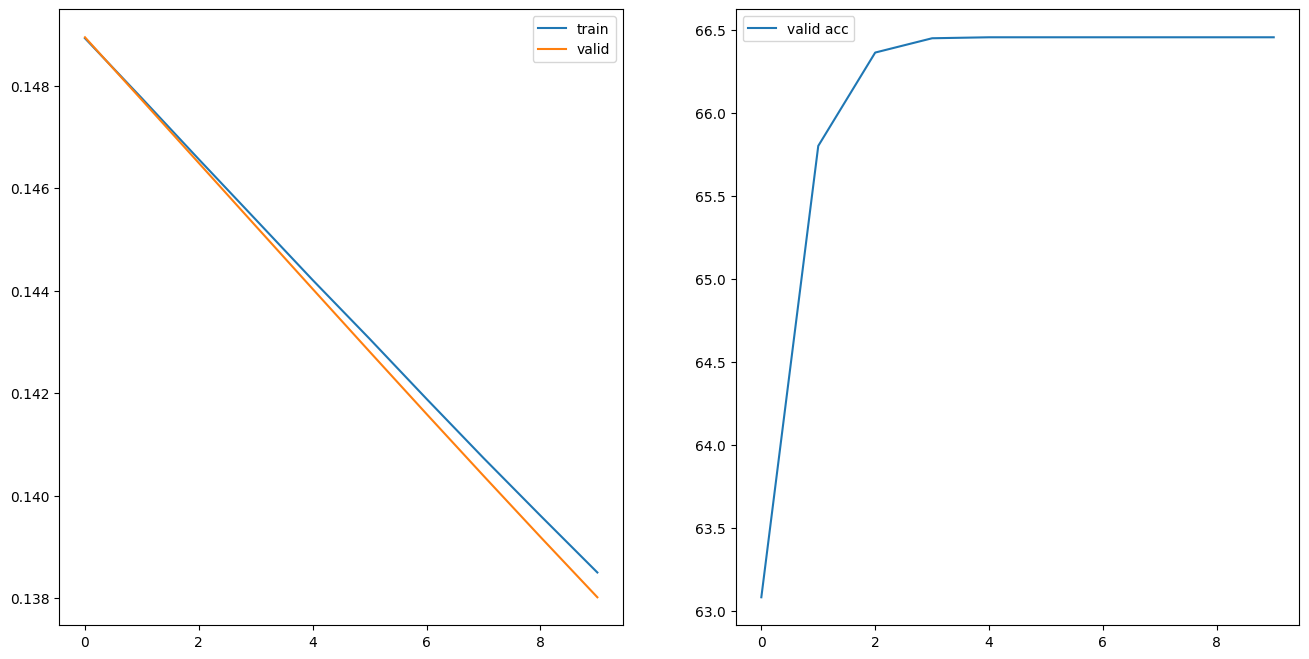

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax1.plot(mean_train_losses, label='train')
ax1.plot(mean_valid_losses, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(valid_acc_list, label='valid acc')
ax2.legend()

# Acccuracy on Testdata

In [ ]:
def test_acc(model):
  correct = 0
  total = 0
  with torch.no_grad():
    for i in range(len(x_test_ts[:,0])):
      y_pred_t = model(x_test_ts)
      _, predicted = torch.max(y_pred_t, 1)
      _, gt = torch.max(y_test_ts, 1)
      correct += (predicted == gt).sum().item()
      total += y_test_ts.size(0)
  accuracy = 100*correct/total
  print('Accuracy of testdata: {:.3f}%'.format(accuracy))

test_acc(model)

Accuracy of testdata: 66.079%


#Tuning learning rate with Bayerian optimazation 

In [ ]:
!pip install torch torchvision
!pip install gpytorch
!pip install numpy
!pip install scipy
!pip install tqdm
!pip install ax-platform


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 17.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.8/521.8 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 40.0 MB/s eta 0:00:00
   

In [ ]:
import numpy as np
from scipy.stats import norm, loguniform
from ax.utils.tutorials.cnn_utils import load_mnist, train, evaluate, CNN
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
from typing import Dict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from numpy.random import random

Train function

In [ ]:
def train(
        net: torch.nn.Module,
        parameters: Dict[str, float],
        inputs: torch.FloatTensor,
        labels: torch.FloatTensor,
) -> nn.Module:
    net.train()
    criterion = nn.MSELoss()
    optimizer = Adam(net.parameters(), lr=parameters.get("lr"), eps=2e-8)
    num_epochs, batch_size = 100, 512

    for epoch in range(num_epochs):
            net.train()
            optimizer.zero_grad()
            output = net(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step() 
    return net

Function gen Learning rate

In [ ]:
def sample_lr(size=1):
    return loguniform(0.000001, 0.2).rvs(size)[:, np.newaxis]


# dtype = torch.float
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Accuracy value

In [ ]:
def evaluate(net: torch.nn.Module,
             inputs: torch.FloatTensor,
             labels: torch.FloatTensor,):
  net.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for i in range(len(inputs[:,0])):
      y_pred_v = net(inputs)
      _, predicted = torch.max(y_pred_v, 1)
      _, gt = torch.max(labels, 1)
      correct += (predicted == gt).sum().item()
      total += labels.size(0)
  accuracy = 100*correct/total
  return accuracy

Objective function

In [ ]:
def objective(x):
    parameterization = {"lr": x[0]}
    net = Mymodel1(input=28, hidden1=16, hidden2=8, output=5)
    print("Training MLP model: ")
    net = train(net=net, parameters=parameterization, inputs=x_train_ts, labels=y_train_ts)
    acc = evaluate(net=net, inputs=x_valid_ts, labels=y_valid_ts)
    print("Accuracy:", acc, "Hyperparams:", parameterization, '\n')
    return acc


Initialize Prior Gausian process

In [ ]:
import torch
import gpytorch

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


GP Regression: GP model and gaussian likelihood.

In [ ]:
class Regressor():
    def __init__(self, train_x, train_y):
        self.training_iter = 100
        self.X = train_x
        self.y = train_y
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.gp = ExactGPModel(self.X, self.y, self.likelihood)

    def train(self):
        self.gp.train()
        self.likelihood.train()
        optimizer = torch.optim.Adam([
            {'params': self.gp.parameters()},
        ], lr=0.05)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self.gp)
        for i in range(self.training_iter):
            optimizer.zero_grad()
            output = self.gp(self.X)
            loss = -mll(output, self.y)
            loss.backward()
            optimizer.step()

    def predict(self, X):
        self.likelihood.eval()
        self.gp.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.gp(X)
            return self.likelihood(pred)


Define Acquisition function: Expected Improvement (EI)

In [ ]:
def surrogate(model, X):
    distro = model.predict(X)
    return distro.mean, np.sqrt(distro.variance)
 
def acquisition(X, Xsamples, model):
    yhat, _ = surrogate(model, X)
    best = max(yhat)
    mu, std = surrogate(model, Xsamples)
    eps = 0.03
    Z = (mu - best - eps) / std
    ei = (mu - best - eps)*norm.cdf(Z) + std*norm.pdf(Z)
    return ei

def opt_acquisition(X, model, iters):
    Xsamples = torch.from_numpy(sample_lr(iters))
    scores = acquisition(X, Xsamples, model)
    e = 0.08**(len(X)/iters)
    if np.random.random(1)[0] > e:
        ix = np.argmax(scores)
    else:
        ix = np.random.randint(len(scores))
    return Xsamples[ix]


Main loop

In [ ]:
from torch.optim import Adam

print("Collecting initial observations")
X = sample_lr(2)
y = np.asarray([objective(x) for x in X])
X = torch.DoubleTensor(X)
y = torch.DoubleTensor(y)
fmodel = Regressor(X, y)
fmodel.train()

# for visualization purposes
new_X = []
new_y = []
iters = 20


print("START OPTIMIZATION")
for i in range(iters):
    print("Iteration ", i)
    x = opt_acquisition(X, fmodel, iters)
    actual = objective(x)
    est, _ = surrogate(fmodel, torch.DoubleTensor([x]))
    X = np.vstack((X.numpy(), x))
    y = np.hstack((y.numpy(), actual))
    new_X.append(x)
    new_y.append(actual)
    X = torch.tensor(X)
    y = torch.tensor(y)
    fmodel = Regressor(X, y)
    fmodel.train()
ix = np.argmax(y)
print('Best Result:', X[ix, :].numpy(), y[ix].numpy())


Training MLP model: 
Accuracy: 12.423114593535749 Hyperparams: {'lr': 2.993809429473702e-06} 

Training MLP model: 
Accuracy: 66.45445641527914 Hyperparams: {'lr': 0.012840891765472286} 

START OPTIMIZATION
Iteration  0
Training MLP model: 
Accuracy: 66.45445641527914 Hyperparams: {'lr': tensor(0.0026, dtype=torch.float64)} 

Iteration  1
Training MLP model: 
Accuracy: 5.9549461312438785 Hyperparams: {'lr': tensor(1.3382e-06, dtype=torch.float64)} 

Iteration  2
Training MLP model: 
Accuracy: 66.45445641527914 Hyperparams: {'lr': tensor(0.0010, dtype=torch.float64)} 

Iteration  3
Training MLP model: 
Accuracy: 66.45445641527914 Hyperparams: {'lr': tensor(0.0245, dtype=torch.float64)} 

Iteration  4
Training MLP model: 
Accuracy: 66.45445641527914 Hyperparams: {'lr': tensor(0.0130, dtype=torch.float64)} 

Iteration  5
Training MLP model: 
Accuracy: 66.45445641527914 Hyperparams: {'lr': tensor(0.0095, dtype=torch.float64)} 

Iteration  6
Training MLP model: 
Accuracy: 1.949069539666993 

Visualize result

<ipython-input-39-913fb97bf4a0>:16: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  plot_post(X, y, fmodel, np.array(new_X), np.array(new_y))
<ipython-input-39-913fb97bf4a0>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_post(X, y, fmodel, np.array(new_X), np.array(new_y))


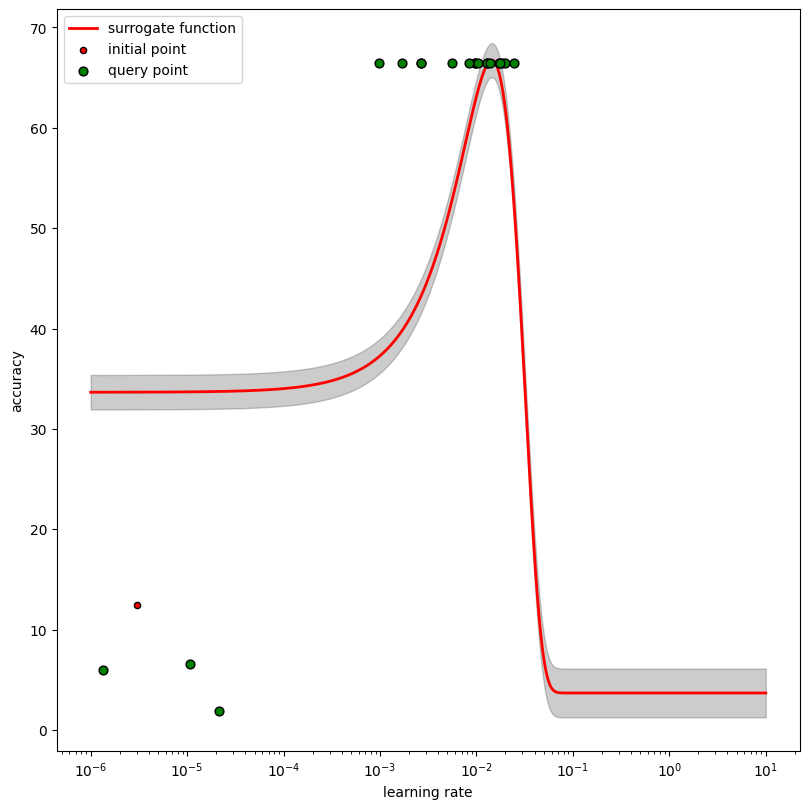

In [ ]:
def plot_post(X, y, gp, new_X, new_y):
    pyplot.figure(figsize=(8, 8))
    X_ = np.logspace(-6, 1, 1000)
    y_mean, y_std = surrogate(gp, torch.from_numpy(X_))
    pyplot.xscale('log')
    pyplot.plot(X_, y_mean, 'r', lw=2, zorder=9, label='surrogate function')
    pyplot.fill_between(X_, y_mean - y_std, y_mean + y_std, alpha=0.2, color='k')
    pyplot.scatter(X[:, 0], y, c='r', s=20, zorder=10, edgecolors=(0, 0, 0), label='initial point')
    pyplot.scatter(new_X, new_y, c='g', s=40, zorder=10, edgecolors=(0, 0, 0), label='query point')
    pyplot.legend(loc='upper left')
    pyplot.tight_layout()
    pyplot.xlabel("learning rate")
    pyplot.ylabel("accuracy")
    pyplot.show()

plot_post(X, y, fmodel, np.array(new_X), np.array(new_y))

